In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.stats import anderson, mannwhitneyu, shapiro, spearmanr

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
sns.set()

In [65]:
df = pd.read_pickle("all_tweets_v15.pkl")
df = df[df.tweet_type == "standard"]
df.head(3)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event,n_photos,n_videos,n_animated_gif,clean_text,word_count,new_lang
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,UNKNOWN,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...,463.0,0.0,0,0,0,"Kararlarındaki temel dayanak, hukukun evrensel...",11,tr
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,UNKNOWN,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,False,2023,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN,N

# All Research Questions:

- Does multimedia attachment in a tweet affect its user engagement?
- Does the sentiment of a tweet affect its user engagement?
- Does the emotion of a tweet affect its user engagement?
- Does the language of a tweet affect its user engagement?
- Does including the trend topic of the day in a tweet affect its user engagement?
- Does the creation time of a tweet affect its user engagement?
- Does including hashtags in a tweet affect its user engagement?
- Is the user engagement of a tweet containing political content different from the tweet without political content?
- Does an important societal event affect the user engagement of a tweet up until 7 days?
- Is the topic of the tweet affect its popularity?

## Testing the normality of likes and retweets

In [66]:
like_counts = df.like_count.to_list()
retweet_counts = df.retweet_count.to_list()

### Shapiroo-Wilk Test

In [67]:
def apply_shapiroo_wilk_test(counts: list[int], variable_name: str):
    print(f"Testing {variable_name} counts")
    stat, p = shapiro(counts)
    print(f"Statistic = {stat:.3f}, p-value = {p:.3f}")
    if p > 0.05:
        print("Sample looks Gaussian (fail to reject H0)")
    else:
        print("Sample does not look Gaussian (reject H0)")


apply_shapiroo_wilk_test(like_counts, "like")
apply_shapiroo_wilk_test(retweet_counts, "retweet")

Testing like counts
Statistic = 0.134, p-value = 0.000
Sample does not look Gaussian (reject H0)
Testing retweet counts
Statistic = 0.235, p-value = 0.000
Sample does not look Gaussian (reject H0)


/Users/hasansalimkanmaz/environments/kuleuven-thesis/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Anderson-Darling Test

In [68]:
def apply_anderson_darling_test(counts: list[int], variable_name: str):
    print(f"Testing {variable_name} counts")
    result = anderson(counts)
    print("\nAnderson-Darling test:")
    print(f"Statistic = {result.statistic:.3f}")
    for i, crit_val in enumerate(result.critical_values):
        if result.statistic < crit_val:
            print(f"{(i+1)*10}%: Sample looks Gaussian (fail to reject H0)")
        else:
            print(f"{(i+1)*10}%: Sample does not look Gaussian (reject H0)")


apply_anderson_darling_test(like_counts, "like")
apply_anderson_darling_test(retweet_counts, "retweet")

Testing like counts

Anderson-Darling test:
Statistic = 25457.045
10%: Sample does not look Gaussian (reject H0)
20%: Sample does not look Gaussian (reject H0)
30%: Sample does not look Gaussian (reject H0)
40%: Sample does not look Gaussian (reject H0)
50%: Sample does not look Gaussian (reject H0)
Testing retweet counts

Anderson-Darling test:
Statistic = 22320.416
10%: Sample does not look Gaussian (reject H0)
20%: Sample does not look Gaussian (reject H0)
30%: Sample does not look Gaussian (reject H0)
40%: Sample does not look Gaussian (reject H0)
50%: Sample does not look Gaussian (reject H0)


### Visual Inspection for normality

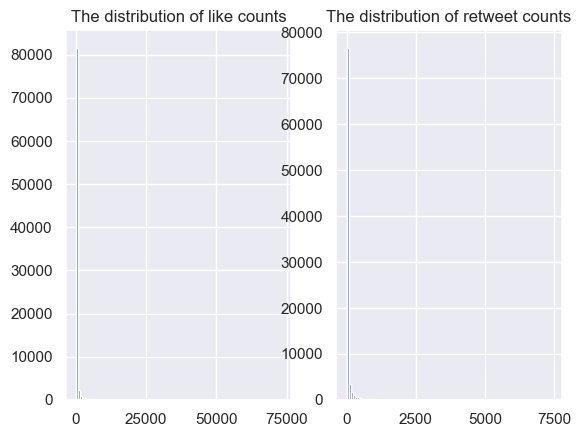

In [69]:
# Plot the distribution of list1
plt.subplot(1, 2, 1)
plt.hist(like_counts, bins=100)
plt.title("The distribution of like counts")

# Plot the distribution of list2
plt.subplot(1, 2, 2)
plt.hist(retweet_counts, bins=100)
plt.title("The distribution of retweet counts")
plt.show()

## Does multimedia attachment in a tweet affect its user engagement?

- Yes, the Mann–Whitney U test is a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X. Below, it is shown that the test is significant and rejects null hypothesis for the tweets with/witout multimedia attachment. In visual inspection, the boxplot are so tiny that the difference can't be seen but it can be seen that the statistics like IQR and median values are different. The tweets with multimedia attachment attract more likes and retweets.

In [70]:
likes_without_media = df[df.has_media != 1].like_count.to_list()
likes_with_media = df[df.has_media == 1].like_count.to_list()
print(
    f"""
The number of tweets with media: {len(likes_with_media)},
The number of tweets without media: {len(likes_without_media)},
"""
)


The number of tweets with media: 36893,
The number of tweets without media: 49640,



In [71]:
result = mannwhitneyu(likes_with_media, likes_without_media)
print(
    f"""
H0 hypothesis is rejected. The mean of like counts for tweets with and without media are significantly different
Test statistic: {result.statistic}, p-value: {result.pvalue}
"""
)


H0 hypothesis is rejected. The mean of like counts for tweets with and without media are significantly different
Test statistic: 1094904997.5, p-value: 0.0



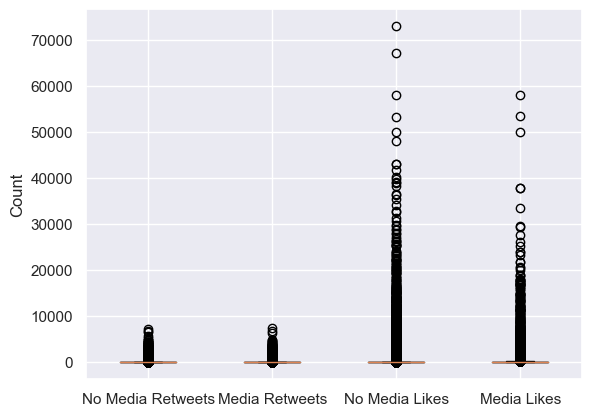

In [72]:
plt.boxplot(
    [
        df.loc[df["has_media"] == 0, "retweet_count"],
        df.loc[df["has_media"] == 1, "retweet_count"],
        df.loc[df["has_media"] == 0, "like_count"],
        df.loc[df["has_media"] == 1, "like_count"],
    ]
)
plt.xticks(
    [1, 2, 3, 4],
    ["No Media Retweets", "Media Retweets", "No Media Likes", "Media Likes"],
)
plt.ylabel("Count")
plt.show()

In [73]:
df.loc[df["has_media"] == 0, "retweet_count"].describe()

count    49640.000000
mean        39.739545
std        191.310164
min          0.000000
25%          2.000000
50%          5.000000
75%         15.000000
max       7150.000000
Name: retweet_count, dtype: float64

In [74]:
df.loc[df["has_media"] == 1, "retweet_count"].describe()

count    36893.000000
mean        69.596861
std        227.745718
min          0.000000
25%          2.000000
50%          8.000000
75%         35.000000
max       7413.000000
Name: retweet_count, dtype: float64

In [75]:
df.loc[df["has_media"] == 0, "like_count"].describe()

count    49640.000000
mean       240.935717
std       1524.515103
min          0.000000
25%          4.000000
50%         13.000000
75%         44.000000
max      73017.000000
Name: like_count, dtype: float64

In [76]:
df.loc[df["has_media"] == 1, "like_count"].describe()

count    36893.000000
mean       217.303825
std       1108.193270
min          0.000000
25%          7.000000
50%         27.000000
75%        107.000000
max      57974.000000
Name: like_count, dtype: float64

## Does the sentiment of a tweet affect its user engagement?
- Yes, according to Spearman's R correlation coefficient, there is a positive correlation between sentiment and like/retweet counts. This is also confirmed via visual inspection based on hexagonally-binned scatterplots.

In [77]:
df_with_sentiment_scores = df[df.lang.isin(["en", "tr", "de", "fr"])]
assert set(df_with_sentiment_scores.lang.unique()) == set(["en", "tr", "de", "fr"])

In [78]:
res = spearmanr(
    df_with_sentiment_scores.sentiment.to_list(),
    df_with_sentiment_scores.like_count.to_list(),
    alternative="greater",
)
print(
    f"""
H0 hypothesis is rejected. There is a positive correlation between like counts and the sentiment of the tweets.
Correlation: {res.correlation}, p-value: {res.pvalue}
"""
)


H0 hypothesis is rejected. There is a positive correlation between like counts and the sentiment of the tweets.
Correlation: 0.07007628472138114, p-value: 1.0306959135591092e-91



In [79]:
res = spearmanr(
    df_with_sentiment_scores.sentiment.to_list(),
    df_with_sentiment_scores.retweet_count.to_list(),
    alternative="greater",
)
print(
    f"""
H0 hypothesis is rejected. There is a positive correlation between retweet counts and the sentiment of the tweets.
Correlation: {res.correlation}, p-value: {res.pvalue}
"""
)


H0 hypothesis is rejected. There is a positive correlation between retweet counts and the sentiment of the tweets.
Correlation: 0.05569700879426289, p-value: 1.1064654269600274e-58



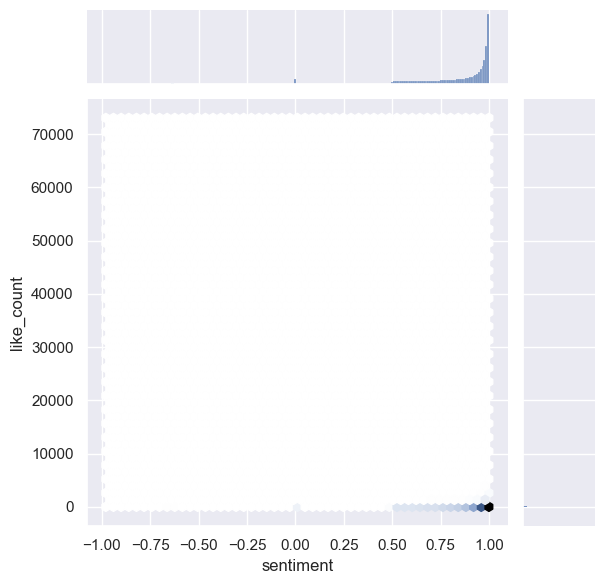

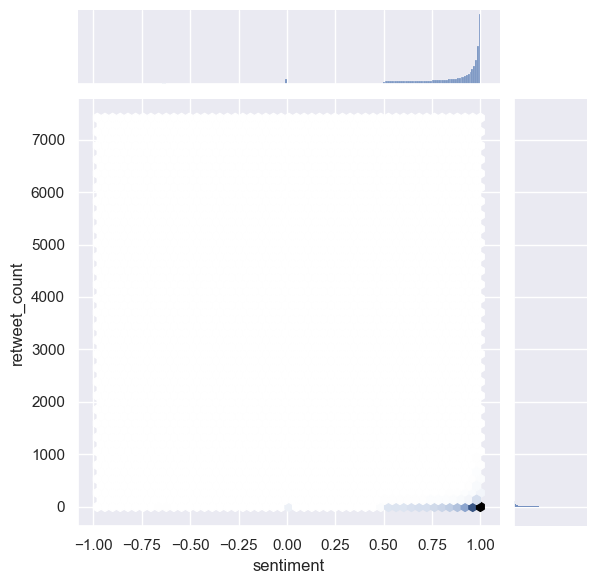

In [81]:
# Plot a hexbin plot for the x and y columns in the first subplot
sns.jointplot(x="sentiment", y="like_count", data=df_with_sentiment_scores, kind="hex")
axs[0].set_xlabel("sentiment")
axs[0].set_ylabel("like_count")

# Plot a hexbin plot for the x and z columns in the second subplot
sns.jointplot(
    x="sentiment",
    y="retweet_count",
    data=df_with_sentiment_scores,
    kind="hex",
)
axs[1].set_xlabel("sentiment")
axs[1].set_ylabel("retweet_count")

plt.show()

# Results